In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
import matplotlib.pyplot as plt
%matplotlib inline
import re

In [2]:
anime_db = pd.read_csv('../data/anime.csv')

In [3]:
anime_db.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [4]:
anime_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


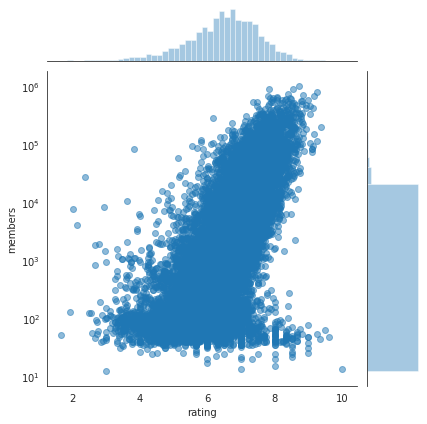

In [5]:
sns.jointplot(x='rating',y='members',data=anime_db,alpha=0.5)
plt.yscale('log')

In [6]:
#check missing values
anime_db.isnull().sum().sort_values(ascending=False)/len(anime_db)

rating      0.018708
genre       0.005043
type        0.002034
members     0.000000
episodes    0.000000
name        0.000000
anime_id    0.000000
dtype: float64

In [7]:
#repalce missing ratings with average
anime_db['rating'].fillna(anime_db["rating"].median(),inplace = True)

In [8]:
#replace missing types with 'unknown'
anime_db['type'].fillna('T/M',inplace = True)

In [9]:
anime_features = pd.concat([anime_db.genre.str.get_dummies(sep=","),
                            pd.get_dummies(anime_db['type']),anime_db.rating],axis=1)

In [10]:
anime_features.head()

,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,Harem,...,Vampire,Yaoi,Movie,Music,ONA,OVA,Special,T/M,TV,rating
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,9.37
1,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,9.26
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,9.25
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,9.17
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,9.16


In [11]:
#remove special characters from the names
anime_db["name"] = anime_db["name"].map(lambda name:re.sub('[^A-Za-z0-9]+', " ", name))

In [12]:
#use MaxBsScaler to scale the features from 1-0, while preserving sparsity
from sklearn.preprocessing import MaxAbsScaler
max_abs_scaler = MaxAbsScaler()
anime_features = max_abs_scaler.fit_transform(anime_features)

In [13]:
#build a model using the unsupervised verion of K-Nearest Neighbors
from sklearn.neighbors import NearestNeighbors

In [14]:
nn_model = NearestNeighbors(n_neighbors=10,algorithm='auto').fit(anime_features)

In [15]:
#Obtain the indices of and distances to the the nearest K neighbors of each point.
distances, indices = nn_model.kneighbors(anime_features)

In [19]:
def similar_anime_content(query):
    if query not in anime_db['name']:
        N = anime_db[anime_db['name'] == query].index[0]
        print('Similar Anime to "{}":'.format(query))
        for n in indices[N][1:]:
            print('Anime: {} \n Genre: {}; Average ratings: {}; Format: {}'.format(anime_db.name[n],
                                                                      anime_db.genre[n],
                                                                      anime_db.rating[n],anime_db['type'][n])) 
        
    else:
        print('The anime {} does not exist in our database.'.format(query))

In [17]:
similar_anime_content('Berserk')

Similar Anime to "Berserk":
Anime: Berserk 2016  
 Genre: Action, Adventure, Demons, Drama, Fantasy, Horror, Military, Romance, Seinen, Supernatural; Average ratings: 6.81; Format: TV
Anime: Berserk 2017  
 Genre: Action, Adventure, Demons, Drama, Fantasy, Horror, Magic, Military, Romance, Supernatural; Average ratings: 6.57; Format: TV
Anime: Berserk Ougon Jidai hen III Kourin 
 Genre: Action, Adventure, Demons, Drama, Fantasy, Horror, Military, Seinen, Supernatural; Average ratings: 8.33; Format: Movie
Anime: Berserk Ougon Jidai hen II Doldrey Kouryaku 
 Genre: Action, Adventure, Demons, Drama, Fantasy, Horror, Military, Seinen, Supernatural; Average ratings: 8.09; Format: Movie
Anime: Berserk Ougon Jidai hen I Haou no Tamago 
 Genre: Action, Adventure, Demons, Fantasy, Military, Seinen, Supernatural; Average ratings: 7.91; Format: Movie
Anime: Elfen Lied 
 Genre: Action, Drama, Horror, Psychological, Romance, Seinen, Supernatural; Average ratings: 7.85; Format: TV
Anime: Shakugan no

In [20]:
name_string = anime_db.name.str.split(' ')

In [21]:
def similar_anime_by_name(query):  
    n = 0
    print('Similar Anime to "{}":'.format(query))
    for i, name in enumerate(anime_db.name):
        if query in name:
            print('Anime: {}; Format: {}'.format(anime_db.name[i],anime_db['type'][i]))
            n+=1
    if n == 0:
        print('No anime with a name similar to "{}" exists in our database.'.format(query))


In [22]:
similar_anime_by_name('Berserk')

Similar Anime to "Berserk":
Anime: Berserk; Format: TV
Anime: Berserk Ougon Jidai hen III Kourin; Format: Movie
Anime: Berserk Ougon Jidai hen II Doldrey Kouryaku; Format: Movie
Anime: Berserk Ougon Jidai hen I Haou no Tamago; Format: Movie
Anime: Berserk 2016 ; Format: TV
Anime: Berserk 2017 ; Format: TV


In [23]:
anime_db[anime_db.members > 100].sort_values('rating',ascending=False).head(10)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama 039,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
5,32935,Haikyuu Karasuno Koukou VS Shiratorizawa Gakue...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
6,11061,Hunter x Hunter 2011,"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
7,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679
9,15417,Gintama 039 Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,13,9.11,81109
8,15335,Gintama Movie Kanketsu hen Yorozuya yo Eien Nare,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534


In [24]:
anime_db[anime_db['type'] == 'Movie'][anime_db.members > 100].sort_values('rating',ascending=False).head(10)

/home/hayden/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
8,15335,Gintama Movie Kanketsu hen Yorozuya yo Eien Nare,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534
11,28851,Koe no Katachi,"Drama, School, Shounen",Movie,1,9.05,102733
15,199,Sen to Chihiro no Kamikakushi,"Adventure, Drama, Supernatural",Movie,1,8.93,466254
18,12355,Ookami Kodomo no Ame to Yuki,"Fantasy, Slice of Life",Movie,1,8.84,226193
24,164,Mononoke Hime,"Action, Adventure, Fantasy",Movie,1,8.81,339556
25,7311,Suzumiya Haruhi no Shoushitsu,"Comedy, Mystery, Romance, School, Sci-Fi, Supe...",Movie,1,8.81,240297
33,28957,Mushishi Zoku Shou Suzu no Shizuku,"Adventure, Fantasy, Historical, Mystery, Seine...",Movie,1,8.75,32266
35,431,Howl no Ugoku Shiro,"Adventure, Drama, Fantasy, Romance",Movie,1,8.74,333186
37,31757,Kizumonogatari II Nekketsu hen,"Action, Mystery, Supernatural, Vampire",Movie,1,8.73,34347
